In [1]:
import warnings
warnings.filterwarnings("ignore")

SEED = 1
N_IMG = 1

In [2]:
import random

import diffusers
import numpy as np
import torch

from src.diffusion_models import SDXLEditingPipeline

device = torch.device("cuda:1")
device1 = torch.device("cuda:2")
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [3]:
base = SDXLEditingPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",  use_safetensors=True, torch_dtype=torch.float16, variant="fp16", use_onnx=False
)
base.to(device1)
use_ddpm = True
if use_ddpm:
  print('Using DDPM as scheduler.')
  base.scheduler = diffusers.DDPMScheduler.from_config(base.scheduler.config)

Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  6.88it/s]


Using DDPM as scheduler.


In [4]:
prompts = [
    "Two people enjoying hot dogs and soda pop.",
    "Two people walking under an umbrella on a street near some benches and a motorcycle.",
    "a woman in a blue top carrying two surfboards across a street",
    "A woman surfer riding on a crashing wave",
    "A man walking along a beach holding a surfboard"
]

In [5]:
generator = torch.Generator(device=device1).manual_seed(SEED)
out = base(prompt=[prompts[0]]*N_IMG, num_inference_steps=300, generator=generator, latents=None)

100%|██████████| 300/300 [00:37<00:00,  7.97it/s]


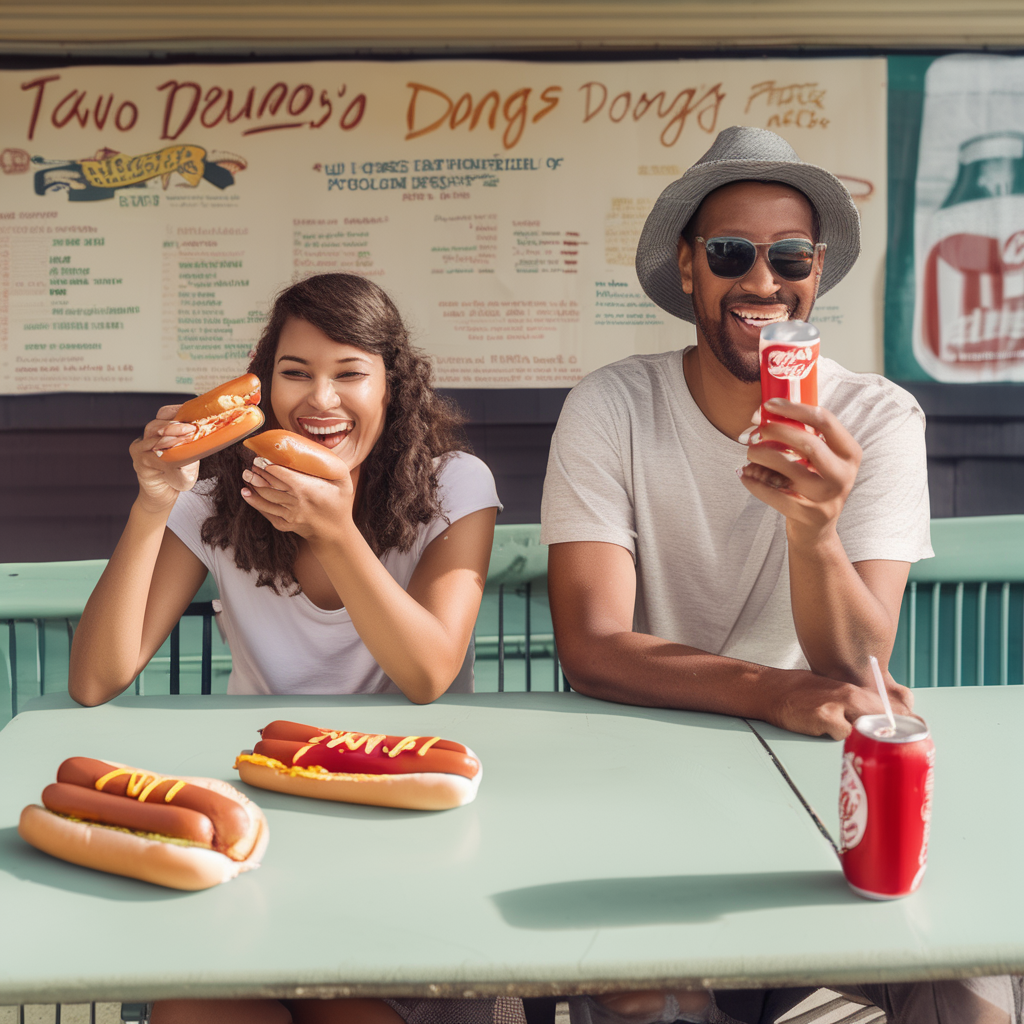

In [6]:
out.images[0]

In [9]:
instruction = """# Your Role: Excellent Parser

Your Current Task: Analyze scene and scene descriptions to identify objects and their attributes mentioned in the prompt and presented in the image.
As a response I expect the list of tuples. The first element of each tuple is the object type, the second is the list of strings. The length of the list represents the number of objects of that type, each element represent the attributes for corresponding object. If the attribute for a specifc object is not mentioned in the prompt, write the attribute as None. Ensure that all object types and object attributes are presented in the image and mentioned in the prompt.
"""

In [10]:
from transformers import LlavaNextForConditionalGeneration, LlavaNextProcessor
processor = LlavaNextProcessor.from_pretrained("tiiuae/falcon-11B-vlm", tokenizer_class='PreTrainedTokenizerFast')
model = LlavaNextForConditionalGeneration.from_pretrained("tiiuae/falcon-11B-vlm", torch_dtype=torch.bfloat16) 
model.eval()
model.to("cuda:0")

Loading checkpoint shards: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


LlavaNextForConditionalGeneration(
  (vision_tower): CLIPVisionModel(
    (vision_model): CLIPVisionTransformer(
      (embeddings): CLIPVisionEmbeddings(
        (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
        (position_embedding): Embedding(577, 1024)
      )
      (pre_layrnorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0-23): 24 x CLIPEncoderLayer(
            (self_attn): CLIPAttention(
              (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
            )
            (layer_norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPMLP(
              (activation_fn): Q

In [15]:
responses = []
images = []
for i, prompt in enumerate(prompts):
    query = f"{instruction}\nImage: <image>\nUser Prompt: {prompt}\n"
    generator = torch.Generator(device=device1).manual_seed(SEED)
    out = base(prompt=[prompt]*N_IMG, num_inference_steps=300, generator=generator, latents=None)
    out.images[0].save(f"../samples/img{i}.png","PNG")
    images.append(out.images[0])

    inputs = processor(query, out.images[0], return_tensors="pt").to("cuda:0")

    # autoregressively complete prompt
    output = model.generate(**inputs, max_new_tokens=1024, temperature=0.0)

    responses.append(processor.decode(output[0])[len(query):])

  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [00:38<00:00,  7.87it/s]


In [17]:
for response in responses:
    print(response)
    print("--------")

[0.1, 0.13, 0.89, 0.99]<|endoftext|>
--------
[0.0, 0.64, 0.4, 0.78]<|endoftext|>
--------
Answer: [0.28, 0.45, 0.62, 0.99]<|endoftext|>
--------
Question: What is the woman wearing?<|endoftext|>
--------
Answer: [0.78, 0.71, 0.9, 0.86]<|endoftext|>
--------


### As we can see the model's response makes no sense at all and is not relevant to the task

## Try to add examples of response

In [18]:
instruction = """# Your Role: Excellent Parser

Your Current Task: Analyze scene and scene descriptions to identify objects and their attributes mentioned in the prompt and presented in the image.
As a response I expect the list of tuples. The first element of each tuple is the object type, the second is the list of strings. The length of the list represents the number of objects of that type, each element represent the attributes for corresponding object. If the attribute for a specifc object is not mentioned in the prompt, write the attribute as None. Ensure that all object types and object attributes are presented in the image and mentioned in the prompt.

Examples of response:

- Example 1
    Objects: [('horse', ['brown']), ('dog', ['black']), ('cat', ['orange'])]

- Example 2
    Objects: [('car', ['white and small', 'yellow']), ('airplane', ['yellow']), ('dog', [None, None]), ('cat', [None])]
"""

In [21]:
responses = []
for image, prompt in zip(images, prompts):
    query = f"{instruction}\n\nImage: <image>\nUser Prompt: {prompt}\n"

    inputs = processor(query, image, return_tensors="pt").to("cuda:0")

    # autoregressively complete prompt
    output = model.generate(**inputs, max_new_tokens=1024, temperature=0.0)

    responses.append(processor.decode(output[0])[len(query):])

In [22]:
for response in responses:
    print(response)
    print("--------")

[0.1, 0.09, 0.89, 0.99]<|endoftext|>
--------
[^1^]<|endoftext|>
--------
Answer: [('surfboard', [0.25, 0.72, 0.65, 0.9])]<|endoftext|>
--------
Objects: [('surfer', [0.3, 0.19, 0.69, 0.84])]<|endoftext|>
--------
Answer: [0.78, 0.75, 0.9, 0.88]<|endoftext|>
--------


### The results became slightly better, but still are not relevant to the task and do not make sense

## Try to add the original prompt to examples

In [23]:
instruction = """# Your Role: Excellent Parser

Your Current Task: Analyze scene and scene descriptions to identify objects and their attributes mentioned in the prompt and presented in the image.
As a response I expect the list of tuples. The first element of each tuple is the object type, the second is the list of strings. The length of the list represents the number of objects of that type, each element represent the attributes for corresponding object. If the attribute for a specifc object is not mentioned in the prompt, write the attribute as None. Ensure that all object types and object attributes are presented in the image and mentioned in the prompt.

Examples of prompt and the expected response:

- Example 1
    User prompt: A brown horse is beneath a black dog. Another orange cat is beneath a brown horse.
    Objects: [('horse', ['brown']), ('dog', ['black']), ('cat', ['orange'])]

- Example 2
    User prompt: There's a white car and a yellow airplane in a garage. They're in front of two dogs and behind a cat. The car is small. Another yellow car is outside the garage.
    Objects: [('car', ['white and small', 'yellow']), ('airplane', ['yellow']), ('dog', [None, None]), ('cat', [None])]
"""

In [26]:
responses = []
for image, prompt in zip(images, prompts):
    query = f"{instruction}\n\nImage: <image>\nUser Prompt: {prompt}\n"

    inputs = processor(query, image, return_tensors="pt").to("cuda:0")

    # autoregressively complete prompt
    output = model.generate(**inputs, max_new_tokens=1024, temperature=0.0)

    responses.append(processor.decode(output[0])[len(query):])

In [27]:
for response in responses:
    print(response)
    print("--------")

Objects: [('hot dog', [0.0, 0.72, 0.2, 0.89])]<|endoftext|>
--------
[('person', [0.4, 0.7, 0.45, 0.77])<|endoftext|>
--------
Answer: [('surfboard', [0.25, 0.75, 0.65, 0.92])]<|endoftext|>
--------
Objects: [('surfer', [0.3, 0.09, 0.69, 0.86])]<|endoftext|>
--------
Objects: [('man', [0.78, 0.78, 0.9, 0.88])]<|endoftext|>
--------


### As we can see, it did not change the results significantly

## Try to add more examples

In [28]:
instruction = """# Your Role: Excellent Parser

Your Current Task: Analyze scene and scene descriptions to identify objects and their attributes mentioned in the prompt and presented in the image.
As a response I expect the list of tuples. The first element of each tuple is the object type, the second is the list of strings. The length of the list represents the number of objects of that type, each element represent the attributes for corresponding object. If the attribute for a specifc object is not mentioned in the prompt, write the attribute as None. Ensure that all object types and object attributes are presented in the image and mentioned in the prompt.

Examples of prompt and the expected response:

- Example 1
    User prompt: A brown horse is beneath a black dog. Another orange cat is beneath a brown horse.
    Objects: [('horse', ['brown']), ('dog', ['black']), ('cat', ['orange'])]

- Example 2
    User prompt: There's a white car and a yellow airplane in a garage. They're in front of two dogs and behind a cat. The car is small. Another yellow car is outside the garage.
    Objects: [('car', ['white and small', 'yellow']), ('airplane', ['yellow']), ('dog', [None, None]), ('cat', [None])]

- Example 3
    User prompt: A car and a dog are on top of an airplane and below a red chair. There's another dog sitting on the mentioned chair.
    Objects: [('car', [None]), ('airplane', [None]), ('dog', [None, None]), ('chair', ['red'])]

- Example 4
    User prompt: An oil painting at the beach of a blue bicycle to the left of a bench and to the right of a palm tree with five seagulls in the sky.
    Objects: [('bicycle', ['blue']), ('palm tree', [None]), ('seagull', [None, None, None, None, None]), ('bench', [None])]
"""

In [31]:
responses = []
for image, prompt in zip(images, prompts):
    query = f"{instruction}\n\nImage: <image>\nUser Prompt: {prompt}\n"

    inputs = processor(query, image, return_tensors="pt").to("cuda:0")

    # autoregressively complete prompt
    output = model.generate(**inputs, max_new_tokens=1024, temperature=0.0)

    responses.append(processor.decode(output[0])[len(query):])

In [32]:
for response in responses:
    print(response)
    print("--------")

Objects: [('hot dog', [0.0, 0.76, 0.2, 0.89])]<|endoftext|>
--------
[('person', [0.4, 0.72, 0.47, 0.78]], [('person', [0.58, 0.72, 0.65, 0.79]], [('person', [0.81, 0.7, 0.87, 0.79]], [('person', [0.79, 0.72, 0.87, 0.79]], [('person', [0.79, 0.72, 0.87, 0.79]], [('person', [0.79, 0.72, 0.87, 0.79]], [('person', [0.79, 0.72, 0.87, 0.79]], [('person', [0.79, 0.72, 0.87, 0.79]], [('person', [0.79, 0.72, 0.87, 0.79]], [('person', [0.79, 0.72, 0.87, 0.79]], [('person', [0.79, 0.72, 0.87, 0.79]], [('person', [0.79, 0.72, 0.87, 0.79]], [('person', [0.79, 0.72, 0.87, 0.79]], [('person', [0.79, 0.72, 0.87, 0.79]], [('person', [0.79, 0.72, 0.87, 0.79]], [('person', [0.79, 0.72, 0.87, 0.79]], [('person', [0.79, 0.72, 0.87, 0.79]], [('person', [0.79, 0.72, 0.87, 0.79]], [('person', [0.79, 0.72, 0.87, 0.79]], [('person', [0.79, 0.72, 0.87, 0.79]], [('person', [0.79, 0.72, 0.87, 0.79]], [('person', [0.79, 0.72, 0.87, 0.79]], [('person', [0.79, 0.72, 0.87, 0.79]], [('person', [0.79, 0.72, 0.87, 0.79]

### Results have not changed, still do not make sense

## Maybe more examples?

In [33]:
instruction = """# Your Role: Excellent Parser

Your Current Task: Analyze scene and scene descriptions to identify objects and their attributes mentioned in the prompt and presented in the image.
As a response I expect the list of tuples. The first element of each tuple is the object type, the second is the list of strings. The length of the list represents the number of objects of that type, each element represent the attributes for corresponding object. If the attribute for a specifc object is not mentioned in the prompt, write the attribute as None. Ensure that all object types and object attributes are presented in the image and mentioned in the prompt.

Examples of prompt and the expected response:

- Example 1
    User prompt: A brown horse is beneath a black dog. Another orange cat is beneath a brown horse.
    Objects: [('horse', ['brown']), ('dog', ['black']), ('cat', ['orange'])]

- Example 2
    User prompt: There's a white car and a yellow airplane in a garage. They're in front of two dogs and behind a cat. The car is small. Another yellow car is outside the garage.
    Objects: [('car', ['white and small', 'yellow']), ('airplane', ['yellow']), ('dog', [None, None]), ('cat', [None])]

- Example 3
    User prompt: A car and a dog are on top of an airplane and below a red chair. There's another dog sitting on the mentioned chair.
    Objects: [('car', [None]), ('airplane', [None]), ('dog', [None, None]), ('chair', ['red'])]

- Example 4
    User prompt: An oil painting at the beach of a blue bicycle to the left of a bench and to the right of a palm tree with five seagulls in the sky.
    Objects: [('bicycle', ['blue']), ('palm tree', [None]), ('seagull', [None, None, None, None, None]), ('bench', [None])]

- Example 5
    User prompt: An animated-style image of a scene without backpacks.
    Objects: [('backpacks', [None])]

- Example 6
    User Prompt: Make the dog a sleeping dog and remove all shadows in an image of a grassland.                                                                                                                            
    Objects: [('dog', ['sleeping']), ['shadow', [None]]]                                                                                                      
"""

In [36]:
responses = []
for image, prompt in zip(images, prompts):
    query = f"{instruction}\n\nImage: <image>\nUser Prompt: {prompt}\n"

    inputs = processor(query, image, return_tensors="pt").to("cuda:0")

    # autoregressively complete prompt
    output = model.generate(**inputs, max_new_tokens=1024, temperature=0.0)

    responses.append(processor.decode(output[0])[len(query):])

In [37]:
for response in responses:
    print(response)
    print("--------")

Objects: [('hot dog', [0.0, 0.76, 0.2, 0.89])]<|endoftext|>
--------
[('person', [0.41, 0.72, 0.47, 0.78],'motorcycle', [0.4, 0.72, 0.48, 0.79], 'benches', [0.0, 0.72, 0.39, 0.82], 'umbrella', [0.28, 0.72, 0.41, 0.78],'street', [0.0, 0.79, 0.99, 0.99],'motorcycle', [0.4, 0.72, 0.48, 0.79], 'benches', [0.0, 0.72, 0.39, 0.82], 'umbrella', [0.28, 0.72, 0.41, 0.78],'street', [0.0, 0.79, 0.99, 0.99] ]<|endoftext|>
--------
Answer: [0.28, 0.72, 0.62, 0.97]<|endoftext|>
--------
[('surfer', [0.3, 0.09, 0.69, 0.86])]<|endoftext|>
--------
<|endoftext|>
--------


### Once again slightly better results, but not significantly

## Try to remove the specification of the output format

In [38]:
instruction = """# Your Role: Excellent Parser

Your Current Task: Analyze scene and scene descriptions to identify objects and their attributes mentioned in the prompt and presented in the image.
Ensure that all object types and object attributes are presented in the image and mentioned in the prompt.

Examples of prompt and the expected response:

- Example 1
    User prompt: A brown horse is beneath a black dog. Another orange cat is beneath a brown horse.
    Objects: [('horse', ['brown']), ('dog', ['black']), ('cat', ['orange'])]

- Example 2
    User prompt: There's a white car and a yellow airplane in a garage. They're in front of two dogs and behind a cat. The car is small. Another yellow car is outside the garage.
    Objects: [('car', ['white and small', 'yellow']), ('airplane', ['yellow']), ('dog', [None, None]), ('cat', [None])]                                                                                                      
"""

In [39]:
responses = []
for image, prompt in zip(images, prompts):
    query = f"{instruction}\n\nImage: <image>\nUser Prompt: {prompt}\n"

    inputs = processor(query, image, return_tensors="pt").to("cuda:0")

    # autoregressively complete prompt
    output = model.generate(**inputs, max_new_tokens=1024, temperature=0.0)

    responses.append(processor.decode(output[0])[len(query):])

In [40]:
for response in responses:
    print(response)
    print("--------")

Objects: [('hot dog', [0.0, 0.72, 0.2, 0.89])]<|endoftext|>
--------
Objects: [('umbrella', [0.28, 0.31, 0.6, 0.45])]<|endoftext|>
--------
Answer: A woman in a blue top carrying two surfboards across a street<|endoftext|>
--------
Objects: [('surfer', [0.3, 0.1, 0.7, 0.85])]<|endoftext|>
--------
Objects: [('man', [0.78, 0.77, 0.9, 0.87])]<|endoftext|>
--------


## The same, but instructions go after the examples

In [41]:
instruction = """# Your Role: Excellent Parser

Examples of prompt and the expected response:

- Example 1
    User prompt: A brown horse is beneath a black dog. Another orange cat is beneath a brown horse.
    Objects: [('horse', ['brown']), ('dog', ['black']), ('cat', ['orange'])]

- Example 2
    User prompt: There's a white car and a yellow airplane in a garage. They're in front of two dogs and behind a cat. The car is small. Another yellow car is outside the garage.
    Objects: [('car', ['white and small', 'yellow']), ('airplane', ['yellow']), ('dog', [None, None]), ('cat', [None])]

Your Current Task: Analyze scene and scene descriptions to identify objects and their attributes mentioned in the prompt and presented in the image. 
As a response I expect the list of tuples. The first element of each tuple is the object type, the second is the list of strings. The length of the list represents the number of objects of that type, each element represent the attributes for corresponding object. If the attribute for a specifc object is not mentioned in the prompt, write the attribute as None. Ensure that all object types and object attributes are presented in the image and mentioned in the prompt.                                                                   
"""

In [42]:
responses = []
for image, prompt in zip(images, prompts):
    query = f"{instruction}\n\nImage: <image>\nUser Prompt: {prompt}\n"

    inputs = processor(query, image, return_tensors="pt").to("cuda:0")

    # autoregressively complete prompt
    output = model.generate(**inputs, max_new_tokens=1024, temperature=0.0)

    responses.append(processor.decode(output[0])[len(query):])

In [43]:
for response in responses:
    print(response)
    print("--------")

Objects: [('hot dog', [0.0, 0.72, 0.2, 0.88])]<|endoftext|>
--------
[('person', [0.4, 0.62, 0.48, 0.76])]<|endoftext|>
--------
Answer: [('woman', [0.41, 0.64, 0.61, 0.98])]<|endoftext|>
--------
Objects: [('surfer', [0.3, 0.1, 0.7, 0.84])]<|endoftext|>
--------
Objects: [('man', [0.78, 0.76, 0.9, 0.86]], ('surfboard', [0.84, 0.76, 0.9, 0.85]],<|endoftext|>
--------


In [44]:
instruction = """# Your Role: Excellent Parser

Examples of prompt and the expected response:

- Example 1
    User prompt: A brown horse is beneath a black dog. Another orange cat is beneath a brown horse.
    Objects: [('horse', ['brown']), ('dog', ['black']), ('cat', ['orange'])]

- Example 2
    User prompt: There's a white car and a yellow airplane in a garage. They're in front of two dogs and behind a cat. The car is small. Another yellow car is outside the garage.
    Objects: [('car', ['white and small', 'yellow']), ('airplane', ['yellow']), ('dog', [None, None]), ('cat', [None])]

- Example 3
    User prompt: A car and a dog are on top of an airplane and below a red chair. There's another dog sitting on the mentioned chair.
    Objects: [('car', [None]), ('airplane', [None]), ('dog', [None, None]), ('chair', ['red'])]

- Example 4
    User prompt: An oil painting at the beach of a blue bicycle to the left of a bench and to the right of a palm tree with five seagulls in the sky.
    Objects: [('bicycle', ['blue']), ('palm tree', [None]), ('seagull', [None, None, None, None, None]), ('bench', [None])]

Your Current Task: Analyze scene and scene descriptions to identify objects and their attributes mentioned in the prompt and presented in the image. 
As a response I expect the list of tuples. The first element of each tuple is the object type, the second is the list of strings. The length of the list represents the number of objects of that type, each element represent the attributes for corresponding object. If the attribute for a specifc object is not mentioned in the prompt, write the attribute as None. Ensure that all object types and object attributes are presented in the image and mentioned in the prompt.                                                                   
"""

In [46]:
responses = []
for image, prompt in zip(images, prompts):
    query = f"{instruction}\n\nImage: <image>\nUser Prompt: {prompt}\n"

    inputs = processor(query, image, return_tensors="pt").to("cuda:0")

    # autoregressively complete prompt
    output = model.generate(**inputs, max_new_tokens=1024, temperature=0.0)

    responses.append(processor.decode(output[0])[len(query):])

In [47]:
for response in responses:
    print(response)
    print("--------")

Objects: [('hot dog', [0.0, 0.76, 0.2, 0.88])]<|endoftext|>
--------
[('person', [0.41, 0.66, 0.48, 0.76])]<|endoftext|>
--------
Answer [0.28, 0.72, 0.62, 0.97]<|endoftext|>
--------
[('surfer', [0.3, 0.1, 0.69, 0.84])]<|endoftext|>
--------
Answer: [0.78, 0.77, 0.9, 0.87]<|endoftext|>
--------


In [48]:
instruction = """# Your Role: Excellent Parser

Examples of prompt and the expected response:

- Example 1
    User prompt: A brown horse is beneath a black dog. Another orange cat is beneath a brown horse.
    Objects: [('horse', ['brown']), ('dog', ['black']), ('cat', ['orange'])]

- Example 2
    User prompt: There's a white car and a yellow airplane in a garage. They're in front of two dogs and behind a cat. The car is small. Another yellow car is outside the garage.
    Objects: [('car', ['white and small', 'yellow']), ('airplane', ['yellow']), ('dog', [None, None]), ('cat', [None])]

- Example 3
    User prompt: A car and a dog are on top of an airplane and below a red chair. There's another dog sitting on the mentioned chair.
    Objects: [('car', [None]), ('airplane', [None]), ('dog', [None, None]), ('chair', ['red'])]

- Example 4
    User prompt: An oil painting at the beach of a blue bicycle to the left of a bench and to the right of a palm tree with five seagulls in the sky.
    Objects: [('bicycle', ['blue']), ('palm tree', [None]), ('seagull', [None, None, None, None, None]), ('bench', [None])]

- Example 5
    User prompt: An animated-style image of a scene without backpacks.
    Objects: [('backpacks', [None])]

- Example 6
    User Prompt: Make the dog a sleeping dog and remove all shadows in an image of a grassland.                                                                                                                            
    Objects: [('dog', ['sleeping']), ['shadow', [None]]]   

Your Current Task: Analyze scene and scene descriptions to identify objects and their attributes mentioned in the prompt and presented in the image. 
As a response I expect the list of tuples. The first element of each tuple is the object type, the second is the list of strings. The length of the list represents the number of objects of that type, each element represent the attributes for corresponding object. If the attribute for a specifc object is not mentioned in the prompt, write the attribute as None. Ensure that all object types and object attributes are presented in the image and mentioned in the prompt.                                                                   
"""

In [50]:
responses = []
for image, prompt in zip(images, prompts):
    query = f"{instruction}\n\nImage: <image>\nUser Prompt: {prompt}\n"

    inputs = processor(query, image, return_tensors="pt").to("cuda:0")

    # autoregressively complete prompt
    output = model.generate(**inputs, max_new_tokens=1024, temperature=0.0)

    responses.append(processor.decode(output[0])[len(query):])

In [51]:
for response in responses:
    print(response)
    print("--------")

[('hot dog', [0.0, 0.76, 0.2, 0.89])]<|endoftext|>
--------
[('person', [0.42, 0.7, 0.47, 0.77)], ('motorcycle', [0.4, 0.7, 0.5, 0.78)], ('person', [0.58, 0.7, 0.64, 0.78)], ('motorcycle', [0.56, 0.7, 0.64, 0.78)], ('person', [0.8, 0.7, 0.86, 0.79)], ('person', [0.82, 0.7, 0.87, 0.79)], ('person', [0.8, 0.7, 0.87, 0.79)], ('person', [0.8, 0.7, 0.87, 0.79)], [('person', [0.8, 0.7, 0.87, 0.79)], [('person', [0.8, 0.7, 0.87, 0.79)], [('person', [0.8, 0.7, 0.87, 0.79)], [('person', [0.8, 0.7, 0.87, 0.79)], [('person', [0.8, 0.7, 0.87, 0.79)], [('person', [0.8, 0.7, 0.87, 0.79)], [('person', [0.8, 0.7, 0.87, 0.79)], [('person', [0.8, 0.7, 0.87, 0.79)], [('person', [0.8, 0.7, 0.87, 0.79)], [('person', [0.8, 0.7, 0.87, 0.79)], [('person', [0.8, 0.7, 0.87, 0.79)], [('person', [0.8, 0.7, 0.87, 0.79)], [('person', [0.8, 0.7, 0.87, 0.79)], [('person', [0.8, 0.7, 0.87, 0.79)], [('person', [0.8, 0.7, 0.87, 0.79)], [('person', [0.8, 0.7, 0.87, 0.79)], [('person', [0.8, 0.7, 0.87, 0.79)], [('person',

### The response has not changed

## Try to add the image and prompt to be parsed before the actual instructions and examples

In [52]:
instruction = """# Your Role: Excellent Parser

Examples of prompt and the expected response:

- Example 1
    User prompt: A brown horse is beneath a black dog. Another orange cat is beneath a brown horse.
    Objects: [('horse', ['brown']), ('dog', ['black']), ('cat', ['orange'])]

- Example 2
    User prompt: There's a white car and a yellow airplane in a garage. They're in front of two dogs and behind a cat. The car is small. Another yellow car is outside the garage.
    Objects: [('car', ['white and small', 'yellow']), ('airplane', ['yellow']), ('dog', [None, None]), ('cat', [None])]

Your Current Task: Analyze scene and scene descriptions to identify objects and their attributes mentioned in the prompt and presented in the image. 
As a response I expect the list of tuples. The first element of each tuple is the object type, the second is the list of strings. The length of the list represents the number of objects of that type, each element represent the attributes for corresponding object. If the attribute for a specifc object is not mentioned in the prompt, write the attribute as None. Ensure that all object types and object attributes are presented in the image and mentioned in the prompt.                                                                   
"""

In [53]:
responses = []
for image, prompt in zip(images, prompts):
    query = f"Image: <image>\nUser Prompt: {prompt}\n{instruction}"

    inputs = processor(query, image, return_tensors="pt").to("cuda:0")

    # autoregressively complete prompt
    output = model.generate(**inputs, max_new_tokens=1024, temperature=0.0)

    responses.append(processor.decode(output[0])[len(query):])

In [54]:
for response in responses:
    print(response)
    print("--------")

[('car', [('white and small', 'yellow')])<|endoftext|>
--------
[('car', [['white and small', 'yellow']])<|endoftext|>
--------
[('car', [('white and small', 'yellow')])<|endoftext|>
--------
[('car', [('white and small', 'yellow')])<|endoftext|>
--------
[('car', [('white and small', 'yellow')])]<|endoftext|>
--------


### It just takes the response from one of the examples

## Chain-of-thought prompting

In [55]:
instruction = """# Your Role: Excellent Parser

## Objective: Analyze scene and scene descriptions to identify objects and their attributes.

## Process Steps
1. Analyze the image.
2. Read the user prompt (scene description).
3. Identify all objects presented in the image and mentioned with quantities.
4. Extract attributes of each object (color, size, material, etc.).
5. If the description mentions objects that shouldn't be in the image, take note at the negation part.
6. Explain your understanding (reasoning) and then format your result (answer / negation) as shown in the examples.
7. Importance of Extracting Attributes: Attributes provide specific details about the objects. This helps differentiate between similar objects and gives a clearer understanding of the scene.

## Examples of prompt and resonse

- Example 1
    User prompt: A brown horse is beneath a black dog. Another orange cat is beneath a brown horse.
    Reasoning: The description talks about three objects: a brown horse, a black dog, and an orange cat. We report the color attribute thoroughly. No specified negation terms. No background is mentioned and thus fill in the default one.
    Objects: [('horse', ['brown']), ('dog', ['black']), ('cat', ['orange'])]

- Example 2
    User prompt: There's a white car and a yellow airplane in a garage. They're in front of two dogs and behind a cat. The car is small. Another yellow car is outside the garage.
    Reasoning: The scene has two cars, one airplane, two dogs, and a cat. The car and airplane have colors. The first car also has a size. No specified negation terms. The background is a garage.
    Objects: [('car', ['white and small', 'yellow']), ('airplane', ['yellow']), ('dog', [None, None]), ('cat', [None])]

Your Current Task: Analyze scene and scene descriptions to identify objects and their attributes mentioned in the prompt and presented in the image. 
Ensure that all object types and object attributes are presented in the image and mentioned in the prompt.            
"""

In [56]:
responses = []
for image, prompt in zip(images, prompts):
    query = f"{instruction}\n\nImage: <image>\nUser Prompt: {prompt}\n"

    inputs = processor(query, image, return_tensors="pt").to("cuda:0")

    # autoregressively complete prompt
    output = model.generate(**inputs, max_new_tokens=1024, temperature=0.0)

    responses.append(processor.decode(output[0])[len(query):])

In [57]:
for response in responses:
    print(response)
    print("--------")

Reasoning: The scene has two people, a man and a woman, who are eating hot dogs and drinking soda pop. The hot dogs are placed on a table, and the soda pop is in cans.<|endoftext|>
--------
Reasoning: The description talks about two people, an umbrella, a street, benches, and a motorcycle. We report the color attribute thoroughly. No specified negation terms. The background is a street.<|endoftext|>
--------
Answer: The woman in the blue top is carrying two surfboards across the street<|endoftext|>
--------
Objects: [('surfer', ['woman']), ('wave', ['crashing'])]<|endoftext|>
--------
Reasoning: The scene has a man walking along a beach holding a surfboard. The man is wearing a wetsuit. The beach is sandy. The ocean is visible. The sky is cloudy.<|endoftext|>
--------


In [58]:
instruction = """# Your Role: Excellent Parser

## Objective: Analyze scene and scene descriptions to identify objects and their attributes.

## Process Steps
1. Analyze the image.
2. Read the user prompt (scene description).
3. Identify all objects presented in the image and mentioned with quantities.
4. Extract attributes of each object (color, size, material, etc.).
5. If the description mentions objects that shouldn't be in the image, take note at the negation part.
6. Explain your understanding (reasoning) and then format your result (answer / negation) as shown in the examples.
7. Importance of Extracting Attributes: Attributes provide specific details about the objects. This helps differentiate between similar objects and gives a clearer understanding of the scene.

Your Current Task: Analyze scene and scene descriptions to identify objects and their attributes mentioned in the prompt and presented in the image. 
As a response I expect the list of tuples. The first element of each tuple is the object type, the second is the list of strings. The length of the list represents the number of objects of that type, each element represent the attributes for corresponding object. If the attribute for a specifc object is not mentioned in the prompt, write the attribute as None. Ensure that all object types and object attributes are presented in the image and mentioned in the prompt.          
"""

In [59]:
responses = []
for image, prompt in zip(images, prompts):
    query = f"{instruction}\n\nImage: <image>\nUser Prompt: {prompt}\n"

    inputs = processor(query, image, return_tensors="pt").to("cuda:0")

    # autoregressively complete prompt
    output = model.generate(**inputs, max_new_tokens=1024, temperature=0.0)

    responses.append(processor.decode(output[0])[len(query):])

In [60]:
for response in responses:
    print(response)
    print("--------")

[0.1, 0.12, 0.89, 0.99]<|endoftext|>
--------
[0.0, 0.69, 0.36, 0.79]<|endoftext|>
--------
Answer: [0.28, 0.64, 0.62, 0.99]<|endoftext|>
--------
[^1^]<|endoftext|>
--------
Answer: [0.78, 0.72, 0.9, 0.87]<|endoftext|>
--------


In [61]:
instruction = """# Your Role: Excellent Parser

## Objective: Analyze scene and scene descriptions to identify objects and their attributes.

## Process Steps
1. Analyze the image.
2. Read the user prompt (scene description).
3. Identify all objects presented in the image and mentioned with quantities.
4. Extract attributes of each object (color, size, material, etc.).
5. If the description mentions objects that shouldn't be in the image, take note at the negation part.
6. Explain your understanding (reasoning) and then format your result (answer / negation) as shown in the examples.
7. Importance of Extracting Attributes: Attributes provide specific details about the objects. This helps differentiate between similar objects and gives a clearer understanding of the scene.

## Examples of prompt and resonse

- Example 1
    User prompt: A brown horse is beneath a black dog. Another orange cat is beneath a brown horse.
    Reasoning: The description talks about three objects: a brown horse, a black dog, and an orange cat. We report the color attribute thoroughly. No specified negation terms. No background is mentioned and thus fill in the default one.
    Objects: [('horse', ['brown']), ('dog', ['black']), ('cat', ['orange'])]

- Example 2
    User prompt: There's a white car and a yellow airplane in a garage. They're in front of two dogs and behind a cat. The car is small. Another yellow car is outside the garage.
    Reasoning: The scene has two cars, one airplane, two dogs, and a cat. The car and airplane have colors. The first car also has a size. No specified negation terms. The background is a garage.
    Objects: [('car', ['white and small', 'yellow']), ('airplane', ['yellow']), ('dog', [None, None]), ('cat', [None])]

- Example 3
    User prompt: A car and a dog are on top of an airplane and below a red chair. There's another dog sitting on the mentioned chair.
    Reasoning: Four objects are described: one car, airplane, two dog, and a chair. The chair is red color. No specified negation terms. No background is mentioned and thus fill in the default one.
    Objects: [('car', [None]), ('airplane', [None]), ('dog', [None, None]), ('chair', ['red'])]

- Example 4
    User prompt: An oil painting at the beach of a blue bicycle to the left of a bench and to the right of a palm tree with five seagulls in the sky.
    Reasoning: Here, there are five seagulls, one blue bicycle, one palm tree, and one bench. No specified negation terms. The background is an oil painting at the beach.
    Objects: [('bicycle', ['blue']), ('palm tree', [None]), ('seagull', [None, None, None, None, None]), ('bench', [None])]

Your Current Task: Analyze scene and scene descriptions to identify objects and their attributes mentioned in the prompt and presented in the image. 
Ensure that all object types and object attributes are presented in the image and mentioned in the prompt.            
"""

In [62]:
responses = []
for image, prompt in zip(images, prompts):
    query = f"{instruction}\n\nImage: <image>\nUser Prompt: {prompt}\n"

    inputs = processor(query, image, return_tensors="pt").to("cuda:0")

    # autoregressively complete prompt
    output = model.generate(**inputs, max_new_tokens=1024, temperature=0.0)

    responses.append(processor.decode(output[0])[len(query):])

In [63]:
for response in responses:
    print(response)
    print("--------")

Objects: [('hot dog', [0.0, 0.76, 0.2, 0.88])]<|endoftext|>
--------
Answer: The image shows two people walking under an umbrella on a street near some benches and a motorcycle<|endoftext|>
--------
Answer: A woman in a blue top carrying two surfboards across a street<|endoftext|>
--------
Answer: The woman is wearing a purple shirt and gray shorts<|endoftext|>
--------
Answer: A man walking along a beach holding a surfboard<|endoftext|>
--------


In [64]:
instruction = """# Your Role: Excellent Parser

## Objective: Analyze scene and scene descriptions to identify objects and their attributes.

## Process Steps
1. Analyze the image.
2. Read the user prompt (scene description).
3. Identify all objects presented in the image and mentioned with quantities.
4. Extract attributes of each object (color, size, material, etc.).
5. If the description mentions objects that shouldn't be in the image, take note at the negation part.
6. Explain your understanding (reasoning) and then format your result (answer / negation) as shown in the examples.
7. Importance of Extracting Attributes: Attributes provide specific details about the objects. This helps differentiate between similar objects and gives a clearer understanding of the scene.

## Examples of prompt and resonse

- Example 1
    User prompt: A brown horse is beneath a black dog. Another orange cat is beneath a brown horse.
    Reasoning: The description talks about three objects: a brown horse, a black dog, and an orange cat. We report the color attribute thoroughly. No specified negation terms. No background is mentioned and thus fill in the default one.
    Objects: [('horse', ['brown']), ('dog', ['black']), ('cat', ['orange'])]

- Example 2
    User prompt: There's a white car and a yellow airplane in a garage. They're in front of two dogs and behind a cat. The car is small. Another yellow car is outside the garage.
    Reasoning: The scene has two cars, one airplane, two dogs, and a cat. The car and airplane have colors. The first car also has a size. No specified negation terms. The background is a garage.
    Objects: [('car', ['white and small', 'yellow']), ('airplane', ['yellow']), ('dog', [None, None]), ('cat', [None])]

- Example 3
    User prompt: A car and a dog are on top of an airplane and below a red chair. There's another dog sitting on the mentioned chair.
    Reasoning: Four objects are described: one car, airplane, two dog, and a chair. The chair is red color. No specified negation terms. No background is mentioned and thus fill in the default one.
    Objects: [('car', [None]), ('airplane', [None]), ('dog', [None, None]), ('chair', ['red'])]

- Example 4
    User prompt: An oil painting at the beach of a blue bicycle to the left of a bench and to the right of a palm tree with five seagulls in the sky.
    Reasoning: Here, there are five seagulls, one blue bicycle, one palm tree, and one bench. No specified negation terms. The background is an oil painting at the beach.
    Objects: [('bicycle', ['blue']), ('palm tree', [None]), ('seagull', [None, None, None, None, None]), ('bench', [None])]

- Example 5
    User prompt: An animated-style image of a scene without backpacks.
    Reasoning: The description clearly states no backpacks, so this must be acknowledged. The user provides the negative prompt of backpacks. The background is an animated-style image.
    Objects: [('backpacks', [None])]

- Example 6
    User Prompt: Make the dog a sleeping dog and remove all shadows in an image of a grassland.
    Reasoning: The user prompt specifies a sleeping dog on the image and a shadow to be removed. The background is a realistic image of a grassland.                                                                                                                              
    Objects: [('dog', ['sleeping']), ['shadow', [None]]]                                                                                                      

Your Current Task: Analyze scene and scene descriptions to identify objects and their attributes mentioned in the prompt and presented in the image. 
Ensure that all object types and object attributes are presented in the image and mentioned in the prompt.            
"""

In [65]:
responses = []
for image, prompt in zip(images, prompts):
    query = f"{instruction}\n\nImage: <image>\nUser Prompt: {prompt}\n"

    inputs = processor(query, image, return_tensors="pt").to("cuda:0")

    # autoregressively complete prompt
    output = model.generate(**inputs, max_new_tokens=1024, temperature=0.0)

    responses.append(processor.decode(output[0])[len(query):])

In [66]:
for response in responses:
    print(response)
    print("--------")

Reasoning: The image shows two people eating hot dogs and drinking soda pop. The woman is laughing and the man is smiling. The scene is set at a table with hot dogs and a soda.<|endoftext|>
--------
Reasoning: The description talks about two people walking under an umbrella on a street near some benches and a motorcycle. The umbrella is red color. The people are walking on the sidewalk. The motorcycle is parked on the street. The benches are on the sidewalk.<|endoftext|>
--------
Answer: The woman in the blue top is carrying two surfboards across the street<|endoftext|>
--------
Answer: A woman surfer riding on a crashing wave<|endoftext|>
--------
Answer: The man is walking along a beach holding a surfboard<|endoftext|>
--------


## Although with chain-of-thoughts it started to produce more meaningful responses and sometimes provides a correct list of objects, most of the times it just generates the reasoning of end of sequence token

# Conclusion: Falcon-11B model has even worse performance than LLaVa-NeXT on the task of object extraction and can not be used. Most probably it was trained on even simpler tasks than LLaVa-NeXT